In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2grey

import skimage.io as io
import skimage.util as u

from scipy.ndimage import binary_fill_holes
from skimage.morphology import disk, ball, binary_opening, binary_erosion
from skimage.filters import threshold_minimum
from skimage.filters import threshold_otsu, median, gaussian, threshold_local
from skimage.filters.rank import tophat
from skimage import measure
import time

In [4]:
def plot_large(arr, x, y):
    figure = plt.figure(figsize=(x,y))
    ax = figure.add_subplot(111)
    ax.imshow(arr, cmap='gray')


def get_unimodal_threshold(input_image):
    """Determines optimal unimodal threshold

    https://users.cs.cf.ac.uk/Paul.Rosin/resources/papers/unimodal2.pdf
    https://www.mathworks.com/matlabcentral/fileexchange/45443-rosin-thresholding

    :param np.array input_image: generate mask for this image
    :return float best_threshold: optimal lower threshold for the foreground
     hist
    """

    hist_counts, bin_edges = np.histogram(
        input_image,
        bins=256,
        range=(input_image.min(), np.percentile(input_image, 99.5))
    )
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # assuming that background has the max count
    max_idx = np.argmax(hist_counts)
    int_with_max_count = bin_centers[max_idx]
    p1 = [int_with_max_count, hist_counts[max_idx]]

    # find last non-empty bin
    pos_counts_idx = np.where(hist_counts > 0)[0]
    last_binedge = pos_counts_idx[-1]
    p2 = [bin_centers[last_binedge], hist_counts[last_binedge]]

    best_threshold = -np.inf
    max_dist = -np.inf
    for idx in range(max_idx, last_binedge, 1):
        x0 = bin_centers[idx]
        y0 = hist_counts[idx]
        a = [p1[0] - p2[0], p1[1] - p2[1]]
        b = [x0 - p2[0], y0 - p2[1]]
        cross_ab = a[0] * b[1] - b[0] * a[1]
        per_dist = np.linalg.norm(cross_ab) / np.linalg.norm(a)
        if per_dist > max_dist:
            best_threshold = x0
            max_dist = per_dist
    assert best_threshold > -np.inf, 'Error in unimodal thresholding'
    return best_threshold


def create_unimodal_mask(input_image, str_elem_size=3):
    """Create a mask with unimodal thresholding and morphological operations

    unimodal thresholding seems to oversegment, erode it by a fraction

    :param np.array input_image: generate masks from this image
    :param int str_elem_size: size of the structuring element. typically 3, 5
    :return: mask of input_image, np.array
    """

    if np.min(input_image) == np.max(input_image):
        thr = np.unique(input_image)
    else:
        thr = get_unimodal_threshold(input_image)
    if len(input_image.shape) == 2:
        str_elem = disk(str_elem_size)
    else:
        str_elem = ball(str_elem_size)
    # remove small objects in mask
    thr_image = binary_opening(input_image > thr, str_elem)
    mask = binary_erosion(thr_image, str_elem)
    return mask

def create_otsu_mask(input_image, str_elem_size=3, thr=None):
    """Create a binary mask using morphological operations

    Opening removes small objects in the foreground.

    :param np.array input_image: generate masks from this image
    :param int str_elem_size: size of the structuring element. typically 3, 5
    :return: mask of input_image, np.array
    """

    if thr is None:
        if np.min(input_image) == np.max(input_image):
            thr = np.unique(input_image)
        else:
            thr = threshold_otsu(input_image, nbins=512)
    if len(input_image.shape) == 2:
        str_elem = disk(str_elem_size)
    else:
        str_elem = ball(str_elem_size)
    # remove small objects in mask
    thr_image = binary_opening(input_image > thr, str_elem)
    mask = binary_fill_holes(thr_image)
    return mask

In [7]:
# path_to_cells = '../Plates_given_to_manu/2020-01-15_plate4_AEP_Feb3_6mousesera'
path_to_cells = '/Volumes/GoogleDrive/My Drive/ELISAarrayReader/images_scienion/Plates_given_to_manu/2020-01-15_plate4_AEP_Feb3_6mousesera'
images = [file for file in os.listdir(path_to_cells) if '.png' in file]

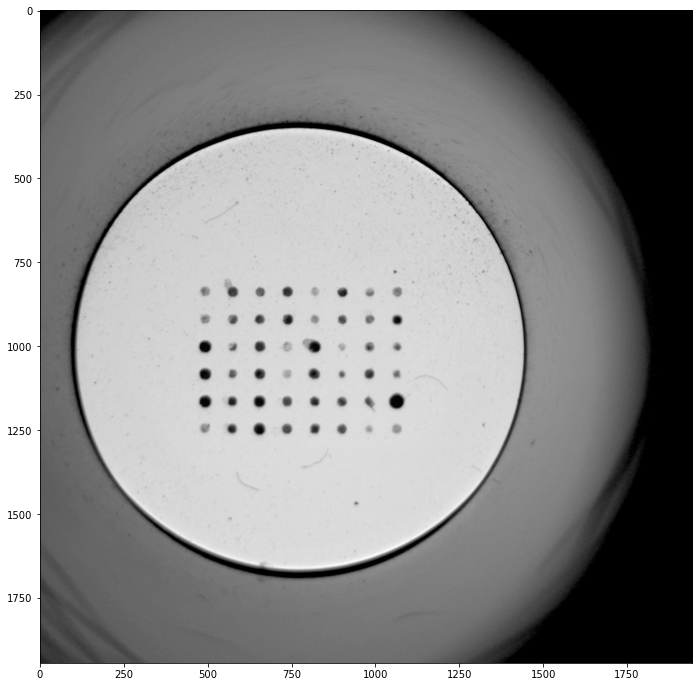

In [8]:
im = io.imread(path_to_cells+os.sep+'A1.png')

image = rgb2grey(im)
plot_large(image, 12,12)

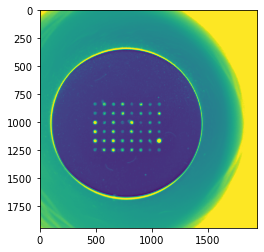

In [9]:
inv = u.invert(image)
plt.imshow(inv)

thresh = threshold_minimum(inv)
thresh

well_mask = create_otsu_mask(image, str_elem_size=10)

labels = measure.label(well_mask)
props = measure.regionprops(labels)

well_cent = [int(x) for x in props[0].centroid]
well_radi = int(props[0].minor_axis_length/2/np.sqrt(2))

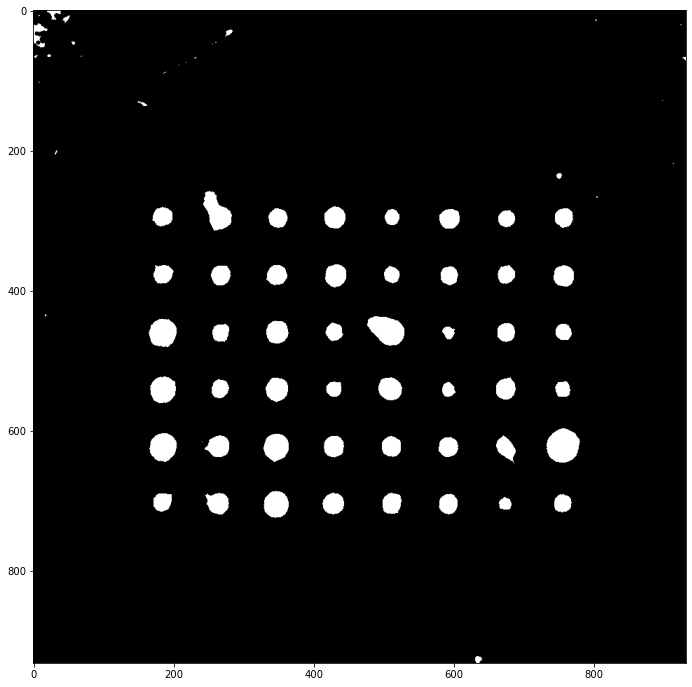

In [10]:
im_inv_crop = inv[well_cent[0]-well_radi:well_cent[0]+well_radi,\
             well_cent[1]-well_radi:well_cent[1]+well_radi]

crop = image[well_cent[0]-well_radi:well_cent[0]+well_radi,\
             well_cent[1]-well_radi:well_cent[1]+well_radi]

spot_mask = create_unimodal_mask(im_inv_crop)
plot_large(spot_mask, 12, 12)

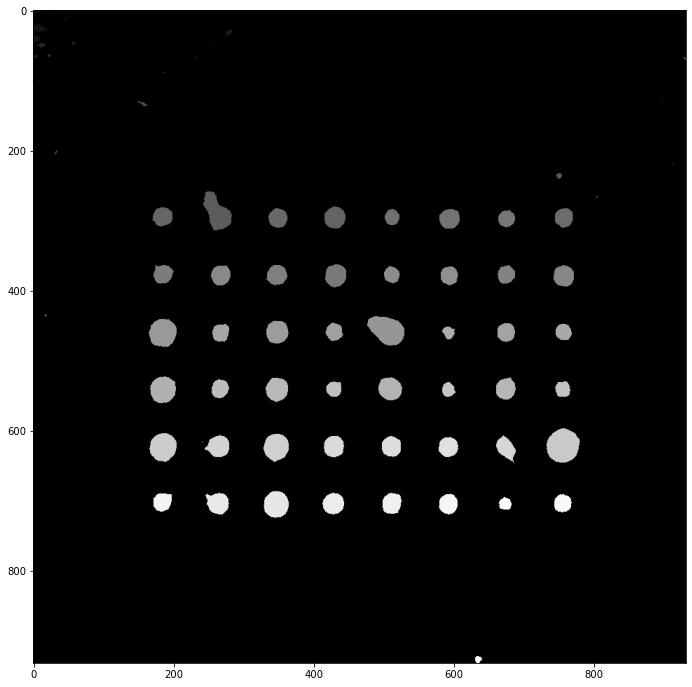

In [11]:
labels = measure.label(spot_mask)
plot_large(labels, 12, 12)

In [12]:
props = measure.regionprops(labels, intensity_image=crop)
# props = [p for p in props if p.eccentricity <0.5]
# props = [p for p in props if p.area > 150]
len(props)

80

In [13]:
# filter centroid map
props = [p for p in props if p.area > 200]
props = [p for p in props if p.eccentricity < 0.5]
len(props)

45

In [14]:
"""
Creates a dictionary whose keys are (centroid_x, centroid_y) scaled to int
    and whose values are region_prop objects
"""
(x, y) = spot_mask.shape
c = 0
# find minx, miny to "zero center" the array
minx = x
miny = y
# find maxx, maxy to scale to array index values
maxx = 0
maxy = 0
for prop in props:
    if prop.area > 100:
        if prop.centroid[0] < minx:
            minx = prop.centroid[0]
        if prop.centroid[1] < miny:
            miny = prop.centroid[1]
        if prop.centroid[0] > maxx:
            maxx = prop.centroid[0]
        if prop.centroid[1] > maxy:
            maxy = prop.centroid[1]
        
print((minx, miny, maxx, maxy))

# use centroid positions to map prop to array index values
chk_list = []
cent_map = {}
for prop in props:
    if prop.area > 100:
        cx, cy = prop.centroid
        csx = cx-minx
        csy = cy-miny
        
        smaxx = maxx-minx
        smaxy = maxy-miny
        
        # "zero center"
        # scale by number of pixels
        # mutiply by number of wells
        norm_cent_x = int(round(5*(csx/smaxx)))
        norm_cent_y = int(round(7*(csy/smaxy)))
        
        print(f"\ncentroid = {prop.centroid}\n\tnorm_cent = {norm_cent_x, norm_cent_y}")
        
        chk_list.append((norm_cent_x, norm_cent_y))
        cent_map[(norm_cent_x, norm_cent_y)] = prop
        c+=1
print(c)

# check if all keys (coordinates) are unique.
if len(chk_list) != len(set(chk_list)):
    print("ERROR, DUPLICATE ENTRIES")

(294.54545454545456, 184.3885918003565, 705.2198515769944, 757.430823117338)

centroid = (295.86418109187747, 430.5006657789614)
	norm_cent = (0, 3)

centroid = (294.54545454545456, 184.6297520661157)
	norm_cent = (0, 0)

centroid = (296.53061224489795, 349.2312925170068)
	norm_cent = (0, 2)

centroid = (295.9316987740806, 757.430823117338)
	norm_cent = (0, 7)

centroid = (295.25935828877004, 512.072192513369)
	norm_cent = (0, 4)

centroid = (297.487915407855, 594.1918429003022)
	norm_cent = (0, 5)

centroid = (297.3793859649123, 675.5043859649123)
	norm_cent = (0, 6)

centroid = (378.54140127388536, 431.66369426751595)
	norm_cent = (1, 3)

centroid = (376.46440677966103, 185.13220338983052)
	norm_cent = (1, 0)

centroid = (377.84954407294833, 347.63981762917933)
	norm_cent = (1, 2)

centroid = (377.1620553359684, 674.9782608695652)
	norm_cent = (1, 6)

centroid = (379.17622377622376, 757.1958041958042)
	norm_cent = (1, 7)

centroid = (378.1023622047244, 267.66771653543304)
	norm_cent 

In [15]:
# assign props to array
props_arr = np.empty(shape=(6, 8), dtype=object)
for key, value in cent_map.items():
    props_arr[key[0],key[1]] = value


In [16]:
(x, y) = spot_mask.shape
c = 0
# find minx, miny to "zero center" the array
minx = x
miny = y
# find maxx, maxy to scale to array index values
maxx = 0
maxy = 0
for prop in props:
    if prop.area > 100:
        if prop.centroid[0] < minx:
            minx = prop.centroid[0]
        if prop.centroid[1] < miny:
            miny = prop.centroid[1]
        if prop.centroid[0] > maxx:
            maxx = prop.centroid[0]
        if prop.centroid[1] > maxy:
            maxy = prop.centroid[1]
        
print((minx, miny, maxx, maxy))

(294.54545454545456, 184.3885918003565, 705.2198515769944, 757.430823117338)


In [17]:
x_vals = []
y_vals = []
for prop in props:
    x_vals.append(prop.centroid[0])
    y_vals.append(prop.centroid[1])

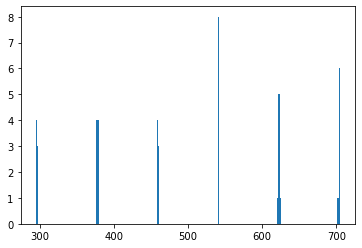

In [68]:
a = plt.hist(x_vals, bins=256)


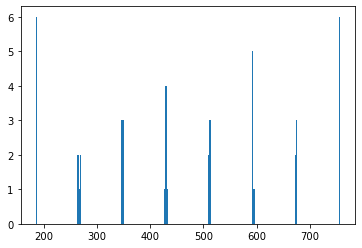

In [69]:
b = plt.hist(y_vals, bins=256)

In [100]:
# find the largest bin corresponding to minimum x
# r = bins / rows
r = int(256 / 6)
hist_min_x = a[0][:r].argmax()

# find the largest bin corresponding to maximum x
hist_max_x = a[0][-r:].argmax()
(hist_min_x, hist_max_x)

(0, 41)

In [104]:
hist_min_pix = a[1][:r][hist_min_x]

hist_max_pix = a[1][-r:][hist_max_x]
(hist_min_pix, hist_max_pix)

(294.54545454545456, 705.2198515769944)

In [135]:
"""
Full procedure using numpy

The output is almost always going to be the min/max bounds of x_vals and y_vals

"""
x_vals = []
y_vals = []
for prop in props:
    x_vals.append(prop.centroid[0])
    y_vals.append(prop.centroid[1])
    
bins_x = int((max(x_vals)-min(x_vals)) / 2)
bins_y = int((max(x_vals)-min(x_vals)) / 2)

hx = np.histogram(x_vals, bins=bins_x)
hy = np.histogram(y_vals, bins=bins_y)

rx = int(bins_x / 6)
ry = int(bins_y / 8)

hist_min_x = hx[0][:rx].argmax()
hist_max_x = hx[0][-rx:].argmax()

hist_min_y = hy[0][:ry].argmax()
hist_max_y = hy[0][-ry:].argmax()

(hist_min_x, hist_max_x, hist_min_y, hist_max_y, rx, ry)

(0, 33, 0, 24, 34, 25)

In [137]:
# extract the pixel coordinates of the far boundaries (centroid)

hist_min_x_pix = ax[1][:rx][hist_min_x]
hist_max_x_pix = ax[1][-rx:][hist_max_x]

hist_min_y_pix = ay[1][:ry][hist_min_y]
hist_max_y_pix = ay[1][-ry:][hist_min_x]

(hist_min_x_pix, hist_max_x_pix, hist_min_y_pix, hist_max_y_pix)

(294.54545454545456, 705.2198515769944, 184.3885918003565, 690.3429521338866)

In [146]:
# find the average bbox size
bbox_area = [a.bbox_area for a in props]
area = np.sum(bbox_area)/len(bbox_area)
side = int(np.sqrt(area))


29

In [214]:
# build an even grid of square masks around the expected spot position
delta_x = hist_max_x_pix - hist_min_x_pix
delta_y = hist_max_y_pix - hist_min_y_pix

space_x = delta_x / 6
space_y = delta_y / 8

blank = np.ones((side, side))
target = np.zeros((spot_mask.shape))

# center position of the origin
origin = (hist_min_x_pix, hist_min_y_pix)
for row in range(6):
    for col in range(8):
        center_x = origin[0]+row*space_x
        center_y = origin[1]+col*space_y
        print(center_x, center_y)
        target[int(center_x-side/2) : int(center_x+side/2), int(center_y-side/2):int(center_y+side/2)] = blank

68.44573283858998
63.24429504169126
294.54545454545456 184.3885918003565
294.54545454545456 247.63288684204775
294.54545454545456 310.877181883739
294.54545454545456 374.1214769254303
294.54545454545456 437.36577196712153
294.54545454545456 500.6100670088128
294.54545454545456 563.854362050504
294.54545454545456 627.0986570921953
362.99118738404457 184.3885918003565
362.99118738404457 247.63288684204775
362.99118738404457 310.877181883739
362.99118738404457 374.1214769254303
362.99118738404457 437.36577196712153
362.99118738404457 500.6100670088128
362.99118738404457 563.854362050504
362.99118738404457 627.0986570921953
431.4369202226345 184.3885918003565
431.4369202226345 247.63288684204775
431.4369202226345 310.877181883739
431.4369202226345 374.1214769254303
431.4369202226345 437.36577196712153
431.4369202226345 500.6100670088128
431.4369202226345 563.854362050504
431.4369202226345 627.0986570921953
499.88265306122446 184.3885918003565
499.88265306122446 247.63288684204775
499.88265

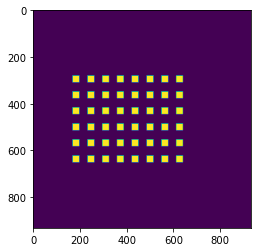

In [167]:
plt.imshow(target)

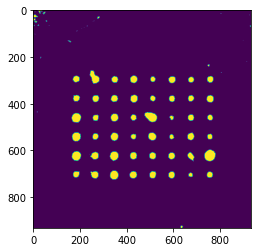

In [168]:
plt.imshow(spot_mask)

In [190]:
props_arr[0][7].centroid
"""
The above approach seems to have not correctly estimated the max_y pix
    the "hist_max_y_pix" is == 690.34, while in this cell we can see that
    the fiducial (row=0, col=7) is at 757
"""

(295.9316987740806, 757.430823117338)

In [197]:
"""
Below we will try another approach.  Here we'll simply use the fiducial coordinates from earlier region props approach
the caveat here is:
1) the fiducials must be identified (no junk around it to obscure the measurement)
2) we have to do the full process (spot_mask -> label/region_prop -> filter -> centroid map -> assign to array)
"""

fiduc_1 = props_arr[0][0]
fiduc_2 = props_arr[0][7]
fiduc_3 = props_arr[5][0]
fiduc_4 = props_arr[5][7]

In [201]:
fiduc_1.centroid, fiduc_2.centroid, fiduc_3.centroid, fiduc_4.centroid

((294.54545454545456, 184.6297520661157),
 (295.9316987740806, 757.430823117338),
 (701.6773618538324, 184.3885918003565),
 (703.6379647749511, 755.5518590998043))

In [209]:
x_min = (fiduc_1.centroid[0] + fiduc_2.centroid[0])/2
y_min = (fiduc_1.centroid[1] + fiduc_3.centroid[1])/2

x_max = (fiduc_3.centroid[0] + fiduc_4.centroid[0])/2
y_max = (fiduc_2.centroid[1] + fiduc_4.centroid[1])/2

x_min, y_min, x_max, y_max

(295.23857665976755, 184.5091719332361, 702.6576633143918, 756.4913411085712)

In [225]:
space_x = (x_max - x_min)/5
space_y = (y_max - y_min)/7

blank = np.ones((side, side))
target = np.zeros((spot_mask.shape))

# center position of the origin
origin = (hist_min_x_pix, hist_min_y_pix)
for row in range(6):
    for col in range(8):
        center_x = origin[0]+row*space_x
        center_y = origin[1]+col*space_y
        target[int(center_x-side/2) : int(center_x+side/2), int(center_y-side/2):int(center_y+side/2)] = blank

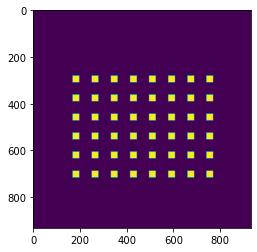

In [226]:
plt.imshow(target)

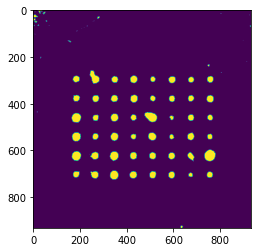

In [220]:
plt.imshow(spot_mask)

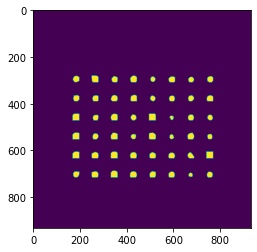

In [242]:
a = target*spot_mask
plt.imshow(a)

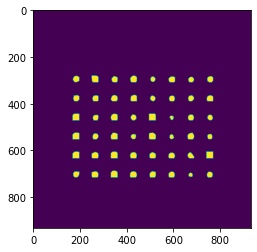

In [43]:
"""
Begin attempts at iterative fitting
Below code represents the result of above experiments
"""

def build_block_array(params_, pix_size=0.0049):
    """
    builds a binary array of squares centered on the expected spot position
    The array dimensions are based on parsed .xml values from the print run

    Daheng camera: IMX226, 12 MP (4000 x 3000), 1.85 um pixel size
    SciReader camera: Camera sensor / mag => 4.9 um/pixel, 2592 x 1944 pixels = 12.701 mm x 9.525 mm.

    :param params_: dict
        param dictionary from "create_xml_dict"
    :param pix_size: float
        size of pix in mm
    :return: np.ndarray, origin

    """

    # fix the pixel size, for now, in mm
    PIX_SIZE = pix_size
#     PIX_SIZE = 0.00185

    n_rows = params_['rows']
    n_cols = params_['columns']

    # values in mm
    v_pitch = params_['v_pitch']
    h_pitch = params_['h_pitch']
    spot_width = params_['spot_width']

    # values in pixels
    v_pix = v_pitch/PIX_SIZE
    h_pix = h_pitch/PIX_SIZE
    spot_pix = spot_width/PIX_SIZE

    # make the box 1.3x the size of the spot, unless it will cause overlap
    side = int(1.3*spot_pix if 1.3*spot_pix < v_pix-1 and 1.3*spot_pix < h_pix-1 else spot_pix)

    # create templates
    x_range = int(v_pix*(n_rows-1)) + side
    y_range = int(h_pix*(n_cols-1)) + side
    target = np.zeros((x_range, y_range))

    # center position of the origin
    origin = (side/2, side/2)
    print(origin)
    for row in range(n_rows):
        for col in range(n_cols):
            center_x = origin[0] + row * v_pix
            center_y = origin[1] + col * h_pix

            # check that the blank fits within the bounds of the target array
            x_min = int(center_x - side / 2) if int(center_x - side / 2) > 0 else 0
            x_max = int(center_x + side / 2) if int(center_x + side / 2) < target.shape[0] else target.shape[0]
            y_min = int(center_y - side / 2) if int(center_y - side / 2) > 0 else 0
            y_max = int(center_y + side / 2) if int(center_y + side / 2) < target.shape[1] else target.shape[1]

            blank = np.ones((x_max-x_min, y_max-y_min))

            target[x_min:x_max, y_min:y_max] = blank

    return target, origin

def build_and_place_block_array(props_array_, spot_mask_, params_, return_type='region'):
    """
    Uses the fiducial centroid positions to build a "block array":
        "block array" is composed of (side, side) regions centered on each expected well position
        There are (rows, cols) of
        np.array of shape = (rows, cols)
        whose elements are np.ones(shape=(side, side))

    :param props_array_:
    :param spot_mask_:
    :param params_:
    :param return_type:
    :return:
    """

    rows = params_['rows']
    cols = params_['columns']

    # fiducials are averaged to find x-y bounds.
    #   one or both can be None, if one is None, this is handled
    #   if two are None, we have to try something else
    fiduc_1 = props_array_[0][0].centroid if props_array_[0][0] else (0, 0)
    fiduc_2 = props_array_[0][cols-1].centroid if props_array_[0][cols-1] else (0, 0)
    fiduc_3 = props_array_[rows-1][0].centroid if props_array_[rows-1][0] else (0, 0)
    fiduc_4 = props_array_[rows-1][cols-1].centroid if props_array_[rows-1][cols-1] else (0, 0)

    # average if two else use one
    x_list_min = [fiduc_1[0], fiduc_2[0]]
    x_min = np.sum(x_list_min) / np.sum(len([v for v in x_list_min if v != 0]))

    y_list_min = [fiduc_1[1], fiduc_3[1]]
    y_min = np.sum(y_list_min) / np.sum(len([v for v in y_list_min if v != 0]))

    x_list_max = [fiduc_3[0], fiduc_4[0]]
    x_max = np.sum(x_list_max) / np.sum(len([v for v in x_list_max if v != 0]))

    y_list_max = [fiduc_2[1], fiduc_4[1]]
    y_max = np.sum(y_list_max) / np.sum(len([v for v in y_list_max if v != 0]))

    # check for NaNs - no fiducial was found
    #   instead, we will use ANY spot at the boundaries to motivate the positioning
    if math.isnan(x_min):
        x_mins = [p.centroid[0] for p in props_array_[0, :] if p]
        x_min = np.average(x_mins)
    if math.isnan(y_min):
        y_mins = [p.centroid[1] for p in props_array_[:, 0] if p]
        y_min = np.average(y_mins)
    if math.isnan(x_max):
        x_maxs = [p.centroid[0] for p in props_array_[rows-1, :] if p]
        x_max = np.average(x_maxs)
    if math.isnan(y_max):
        y_maxs = [p.centroid[1] for p in props_array_[:, cols-1] if p]
        y_max = np.average(y_maxs)

    # build_block_array uses values in the params_ to motivate array dimensions, spacings
    template, temp_origin = build_block_array(params_)

    # center the template origin on the expected fiducial 1
    target = np.zeros(spot_mask_.shape)
    target[int(x_min-temp_origin[0]):int(x_min+template.shape[0]-temp_origin[0]),
           int(y_min-temp_origin[1]):int(y_min+template.shape[1]-temp_origin[1])] = template

    if return_type == 'product':
        return target*spot_mask_
    elif return_type == 'region':
        return target

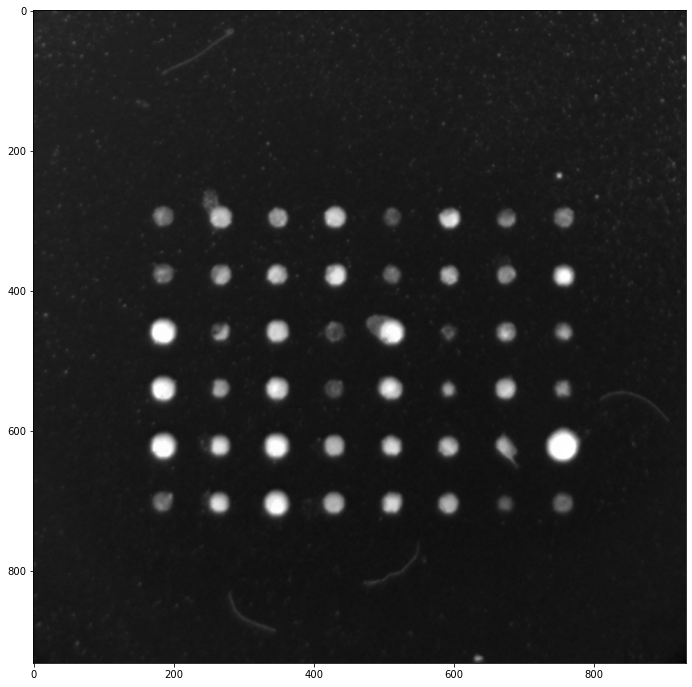

In [71]:
props_arr, spot_mask, crop, im_inv_crop
plot_large(im_inv_crop, 12, 12)

In [33]:
text_path = '/Volumes/GoogleDrive/My Drive/ELISAarrayReader/images_scienion/Plates_given_to_manu/2020-01-15_plate4_AEP_Feb3_6mousesera/8x6_test.conf.xml'
import xmltodict
from xml.parsers.expat import ExpatError
import xml.etree.ElementTree as ET

def create_xml_dict(path_):
    """
    receives an .xml file generated by the Scienion sciReader software
    returns dictionaries containing
        fiducials and control info
        spot info
        replicate info
        additional params

    :param path_: str
    :return: dict, dict, dict, dict
    """
    try:
        with open(path_) as fd:
            doc = xmltodict.parse(fd.read())
    except ExpatError:
        tree = ET.parse(path_)
        xml_data = tree.getroot()
        # here you can change the encoding type to be able to set it to the one you need
        xmlstr = ET.tostring(xml_data, encoding='utf-8', method='xml')
        doc = xmltodict.parse(xmlstr)

    # layout of array
    layout = doc['configuration']['well_configurations']['configuration']['array']['layout']

    # fiducials
    fiduc = layout['marker']

    # spot IDs
    spots = doc['configuration']['well_configurations']['configuration']['array']['spots']['spot']

    # replicates
    repl = doc['configuration']['well_configurations']['configuration']['array']['spots']['multiplet']

    params = dict()
    params['rows'] = int(layout['@rows'])
    params['columns'] = int(layout['@cols'])
    params['v_pitch'] = float(layout['@vspace'])
    params['h_pitch'] = float(layout['@hspace'])
    params['spot_width'] = float(layout['@expected_diameter'])
    params['bg_offset'] = float(layout['@background_offset'])
    params['bg_thickness'] = float(layout['@background_thickness'])
    params['max_diam'] = float(layout['@max_diameter'])
    params['min_diam'] = float(layout['@min_diameter'])

    return fiduc, spots, repl, params

_, _, _, param = create_xml_dict(text_path)

In [47]:
template, temp_center = build_block_array(param)
template.shape, crop.shape

(26.5, 26.5)


((471, 631), (932, 932))

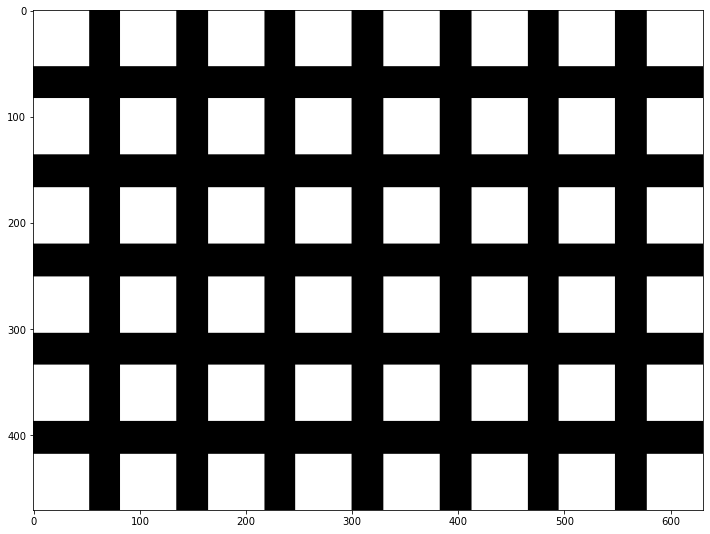

In [46]:
plot_large(template, 12,12)

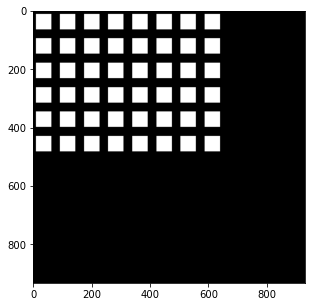

In [114]:
# impose a shift
target = np.zeros_like(crop)
target_x = np.zeros_like(crop)
target_y = np.zeros_like(crop)
new_x, new_y = 10, 10
# bounds are x: 0 -> crop.shape[0] - template.shape[0]
#            y: 0 -> crop.shape[1] - template.shape[1]

# target is new hypothesis
old_x, old_y = 0, 0
target[new_x:template.shape[0]+new_x, new_y:template.shape[1]+new_y] = template
target_x[new_x:template.shape[0]+new_x, old_y:template.shape[1]] = template
target_y[old_x:template.shape[0], new_y:template.shape[1]+new_y] = template
plot_large(target, 5,5)

In [143]:
# calculate loss_x
lx = (im_inv_crop*target_x - im_inv_crop)**2
dlx = 2*(im_inv_crop*target_x - im_inv_crop)

# calculate loss_y
ly = (im_inv_crop*target_y - im_inv_crop)**2
dly = 2*(im_inv_crop*target_y - im_inv_crop)

total_loss = lx+ly
total_loss = (im_inv_crop*target - im_inv_crop)**2


np.sum(dlx), np.sum(total_loss), np.sum(dly)

(-466564.19220549014, 77556.84749141341, -466613.0486211762)

0 225.55714764928157 100.55714764928157
1 226.11429529856315 101.11429529856315
2 226.67144294784472 101.67144294784472
3 227.2285905971263 102.2285905971263
4 227.78573824640787 102.78573824640787
5 228.34288589568945 103.34288589568945
6 228.90003354497102 103.90003354497102
7 229.4571811942526 104.4571811942526
8 230.01432884353417 105.01432884353417
9 230.57147649281575 105.57147649281575
10 231.12862414209732 106.12862414209732
11 231.6857717913789 106.6857717913789
12 232.24291944066047 107.24291944066047
13 232.80006708994205 107.80006708994205
14 233.35721473922362 108.35721473922362
15 233.9143623885052 108.9143623885052
16 234.47151003778677 109.47151003778677
17 235.02865768706835 110.02865768706835
18 235.58580533634992 110.58580533634992
19 236.1429529856315 111.1429529856315
20 236.70010063491307 111.70010063491307
21 237.25724828419465 112.25724828419465
22 237.81439593347622 112.81439593347622
23 238.3715435827578 113.3715435827578
24 238.92869123203937 113.928691232039

204 339.2152681027186 214.21526810272283
205 339.77241575200014 214.7724157520044
206 340.3295634012817 215.32956340128598
207 340.88671105056324 215.88671105056756
208 341.4438586998448 216.44385869984913
209 342.0010063491263 217.0010063491307
210 342.5581539984079 217.55815399841228
211 343.1153016476894 218.11530164769385
212 343.67244929697097 218.67244929697543
213 344.2295969462525 219.229596946257
214 344.78674459553406 219.78674459553858
215 345.3438922448156 220.34389224482015
216 345.90103989409715 220.90103989410173
217 346.4581875433787 221.4581875433833
218 347.01533519266025 222.01533519266488
219 347.5724828419418 222.57248284194645
220 348.12963049122334 223.12963049122803
221 348.6867781405049 223.6867781405096
222 349.24392578978643 224.24392578979118
223 349.801073439068 224.80107343907275
224 350.3582210883495 225.35822108835433
225 350.91536873763107 225.9153687376359
226 351.4725163869126 226.47251638691748
227 352.02966403619416 227.02966403619905
228 352.586811

'\n1) current_x, current_y, next_x, next_y\n2) compute loss_x -> sum across rows, then avg (will be a vector)\n3) compute loss_y -> sum across cols, then avg (will be a vector)\n4) compute deltaX -> \n\nloss is just MSE = (im_inv_crop - im_inv_crop*target)**2\ngrad is 2(im_inv_crop - im_inv_crop*target)\n'

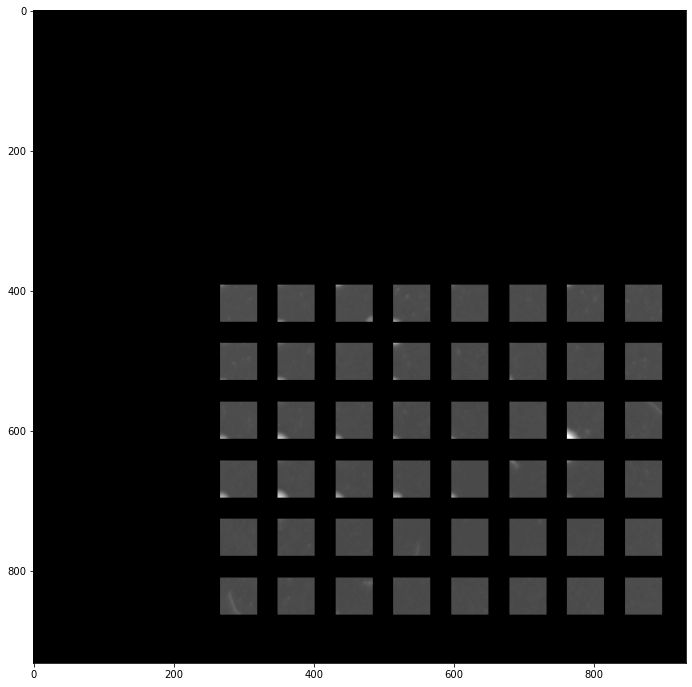

In [149]:
# calculate update
gamma = 0.000001  # Scale step to pixels
precision = 0.000001  # Desired precision of result in pix
max_iters = 300  # Maximum number of iterations
next_x = 225
next_y = 100


def dfx(targ):
    dlx = 2*(im_inv_crop*target_x - im_inv_crop)
    dlx_s = np.sum(dlx)
    return dlx_s
    
def dfy(targ):
    dly = 2*(im_inv_crop*target_y - im_inv_crop)
    dly_s = np.sum(dly)
    return dly_s

def update_x(new_x):
    new_x = int(new_x)
    cy = int(current_y)
    target_x[new_x:template.shape[0]+new_x, cy:template.shape[1]+cy] = template
    
def update_y(new_y):
    new_y = int(new_y)
    cx = int(current_x)
    target_y[cx:template.shape[0]+cx, new_y:template.shape[1]+new_y] = template

def update(new_x, new_y):
    new_x, new_y = int(new_x), int(new_y)
    target[new_x:template.shape[0]+new_x, new_y:template.shape[1]+new_y] = template

for i in range(max_iters):
    target_x = 0.1*np.zeros_like(crop)
    target_y = 0.1*np.zeros_like(crop)
    target = 0.1*np.zeros_like(crop)
    
    current_x = next_x
    current_y = next_y
    next_x = current_x - gamma * dfx(current_x)
    next_y = current_y - gamma * dfy(current_y)
    
    if next_x > im_inv_crop.shape[0] - template.shape[0]:
        next_x = current_x
    if next_y > im_inv_crop.shape[1] - template.shape[1]:
        next_y = current_y
    
    update_x(next_x)
    update_y(next_y)
    update(next_x, next_y)

    step_x = next_x - current_x
    step_y = next_y - current_y
    
    if abs(step_x) <= precision:
        break
    if abs(step_y) <= precision:
        break
        
    print(i, next_x, next_y)

print(f"Minimum at ({next_x},{next_y})")

target[int(next_x):template.shape[0]+int(next_x), int(next_y):template.shape[1]+int(next_y)] = template

plot_large(target*im_inv_crop, 12 ,12)

"""
1) current_x, current_y, next_x, next_y
2) compute loss_x -> sum across rows, then avg (will be a vector)
3) compute loss_y -> sum across cols, then avg (will be a vector)
4) compute deltaX -> 

loss is just MSE = (im_inv_crop - im_inv_crop*target)**2
grad is 2(im_inv_crop - im_inv_crop*target)
"""


# for _ in range(max_iters):
#     current_x = next_x
#     next_x = current_x - gamma * df(current_x)

#     step = next_x - current_x
#     if abs(step) <= precision:
#         break

# print("Minimum at ", next_x)

In [192]:
p = props_arr[3][4]

maxint = np.where(p.intensity_image == p.min_intensity)

p.centroid, p.local_centroid


((540.2018348623853, 509.2511467889908),
 (16.201834862385322, 16.251146788990827))

In [195]:
p.bbox, maxint, p.intensity_image[4,3], p.min_intensity
newx = p.bbox[0]+maxint[0]
newy = p.bbox[1]+maxint[1]

newx, newy

(array([537]), array([509]))

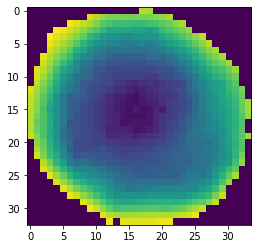

In [189]:
plt.imshow(p.intensity_image)